In [44]:
# general imports
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns

# from our documents
import OurFunctions as of

# from Scikit Learn library
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# from Imb Learn
from imblearn.over_sampling import SMOTENC



In [45]:
ASD_phenotypic_original = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic.csv'))
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_phenotypic_preprocessed.csv'))
ASD_diagnosis = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD_clinical.csv'))

# CLASSIFICATION

First of all, we split the data into train set and test set, to be sure that our classifier is evaluated on data that it had never seen before.

In [46]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(ASD_phenotypic, ASD_diagnosis['DX_GROUP'], test_size=0.3, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (467, 11)
Test set size: (201, 11)


I want to check the balance between classes for each set, to  be sure we are training the classifier using a good split.

In [47]:
class_counts_test = y_test.value_counts(normalize=True)
class_counts_train = y_train.value_counts(normalize=True)
class_count_train_num = y_train.value_counts()

# Stampa il conteggio delle classi per DX_GROUP
print("Class proportions for:")
print("- test set: " + str(class_counts_test))
print("- train set: " + str(class_counts_train))
print("Num subjects involved per "+ str(class_count_train_num))

Class proportions for:
- test set: DX_GROUP
1    0.60199
2    0.39801
Name: proportion, dtype: float64
- train set: DX_GROUP
1    0.603854
2    0.396146
Name: proportion, dtype: float64
Num subjects involved per DX_GROUP
1    282
2    185
Name: count, dtype: int64


# General pipeline

To achieve a more reliable accuracy score we use k-fold cross validation. In this way we are performing the training on different train and validation fold and we avoid to have a better accuracy based only on the subjects we selected.

In [48]:
def general_pipeline(dataset, target, classifier, encoder = True, scaler = True, parameters_grid_search = None, cv = None):

    # Definizione delle metriche da utilizzare come scoring
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1_score': make_scorer(f1_score)
    }

    # Preprocess to make on the train data may include
    # - normalization of the numerical columns
    # - one hot encoding on the categorical columns
    
    categorical_columns = dataset.select_dtypes(include=['object']).columns

    if not encoder:
        transformers = [('num', RobustScaler(), ~dataset.columns.isin(categorical_columns))]
    elif not scaler:
        transformers = [('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)]
    elif not encoder and not scaler:
        transformers = []
    else:
        transformers=[
            ('num', RobustScaler(), ~dataset.columns.isin(categorical_columns)),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ]

    preprocessor = ColumnTransformer(transformers=transformers)

    # We define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    if isinstance(pipeline.named_steps['classifier'], KNeighborsClassifier):
        parameter_type = 'classifier__n_neighbors'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [3, 5, 7, 9, 11]}  # Valori di n_neighbors da esplorare

    if isinstance(pipeline.named_steps['classifier'], RandomForestClassifier):
        parameter_type = 'classifier__n_estimators'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [10, 50, 200, 500, 1000]}  # Valori di n_neighbors da esplorare

    if isinstance(pipeline.named_steps['classifier'], svm.SVC):
        parameter_type = 'classifier__C'
        if parameters_grid_search:
            parameters = {parameter_type: parameters_grid_search}  # Valori di n_neighbors da esplorare
        else:
            parameters = {parameter_type: [1]}  # Valori di n_neighbors da esplorare

    if cv:
        k_folds = cv
    else:
        k_folds = 5

    # Creazione dell'oggetto GridSearchCV
    grid_search = GridSearchCV(pipeline, parameters, cv= k_folds, scoring=scoring, refit='accuracy')

    # Esecuzione della ricerca a griglia
    grid_search.fit(dataset, target)

    # Visualizzazione dei risultati
    print("Risultati della cross-validation per tutte le combinazioni di iperparametri:")

    means_accuracy = grid_search.cv_results_['mean_test_accuracy']
    stds_accuracy = grid_search.cv_results_['std_test_accuracy']
    means_precision = grid_search.cv_results_['mean_test_precision']
    means_recall = grid_search.cv_results_['mean_test_recall']
    means_f1_score = grid_search.cv_results_['mean_test_f1_score']
    params = grid_search.cv_results_['params']

    for mean_acc, std_acc, mean_prec, mean_rec, mean_f1, params in zip(means_accuracy, stds_accuracy, means_precision, means_recall, means_f1_score, params):
        print(f"Parametri: {params}, Accuratezza media: {mean_acc:.3f} (±{std_acc:.3f}), Precision media: {mean_prec:.3f}, Richiamo medio: {mean_rec:.3f}, F1-score medio: {mean_f1:.3f}")

    best_model = grid_search.best_estimator_

    print("\nMiglior parametro trovato:")
    print(grid_search.best_params_[parameter_type])
    print("Accuratezza media con il miglior parametro:", grid_search.best_score_)

    return best_model
    

In [49]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
categorical_features = categorical_columns.tolist()

# Inizializza l'oggetto SMOTE-NC specificando gli indici delle colonne categoriche
sampler = SMOTENC(categorical_features=categorical_features, random_state=42)

# Applica SMOTE-NC per generare nuovi esempi sintetici
X_SMOTE, Y_SMOTE = sampler.fit_resample(X_train, y_train)

# Stampa la distribuzione delle classi dopo l'applicazione di SMOTE-NC
print(pd.Series(Y_SMOTE).value_counts(normalize=True))
print("Num subjects involved per")
print(pd.Series(Y_SMOTE).value_counts())

DX_GROUP
1    0.5
2    0.5
Name: proportion, dtype: float64
Num subjects involved per
DX_GROUP
1    282
2    282
Name: count, dtype: int64


# K-NEAREST NEIGHBOOR

In [50]:
classifier = KNeighborsClassifier()
knn_model = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_neighbors': 3}, Accuratezza media: 0.915 (±0.037), Precision media: 0.961, Richiamo medio: 0.865, F1-score medio: 0.909
Parametri: {'classifier__n_neighbors': 5}, Accuratezza media: 0.913 (±0.031), Precision media: 0.958, Richiamo medio: 0.865, F1-score medio: 0.908
Parametri: {'classifier__n_neighbors': 7}, Accuratezza media: 0.899 (±0.030), Precision media: 0.964, Richiamo medio: 0.830, F1-score medio: 0.891
Parametri: {'classifier__n_neighbors': 9}, Accuratezza media: 0.892 (±0.033), Precision media: 0.971, Richiamo medio: 0.808, F1-score medio: 0.881
Parametri: {'classifier__n_neighbors': 11}, Accuratezza media: 0.886 (±0.035), Precision media: 0.971, Richiamo medio: 0.798, F1-score medio: 0.874

Miglior parametro trovato:
3
Accuratezza media con il miglior parametro: 0.9148546144121366


In [51]:
# Valutazione del modello sui dati di test
y_pred = knn_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.910
Precisione: 0.972
Richiamo: 0.876
F1-score: 0.922


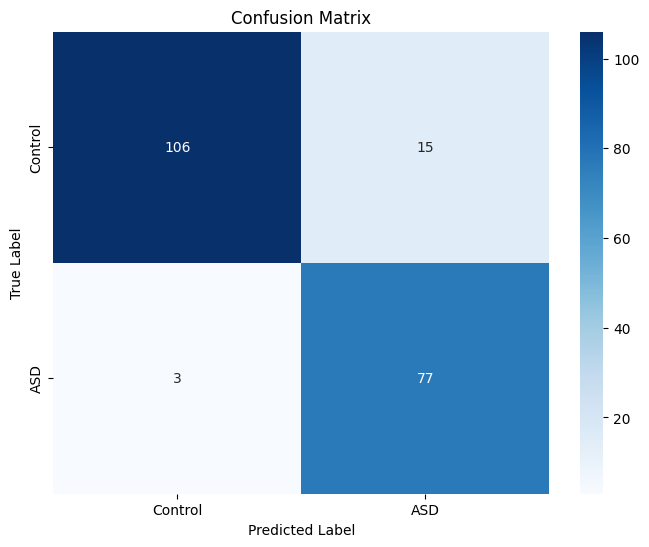

In [52]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [53]:
'''
Visualizzare l'effetto del modello sui dati attraverso un grafico di decisione

# Riduzione della dimensione a 2D usando PCA (se ci sono più di due caratteristiche)
pca = PCA(n_components=2)
ASD_phenotypic_2d = pca.fit_transform(ASD_phenotypic)

# Definizione del pipeline con PCA e il miglior modello trovato
pipeline_2d = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('classifier', KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors']))
])

# Adattamento del pipeline
pipeline_2d.fit(ASD_phenotypic, ASD_diagnosis['DX_GROUP'])

# Creazione di una meshgrid per la visualizzazione delle regioni di decisione
h = .02  # passo della meshgrid
x_min, x_max = ASD_phenotypic_2d[:, 0].min() - 1, ASD_phenotypic_2d[:, 0].max() + 1
y_min, y_max = ASD_phenotypic_2d[:, 1].min() - 1, ASD_phenotypic_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predizione su ogni punto della meshgrid
Z = pipeline_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Creazione di un colormap per la visualizzazione delle regioni di decisione
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Visualizzazione delle regioni di decisione
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=cmap_light)

# Visualizzazione dei punti di addestramento
scatter = plt.scatter(ASD_phenotypic_2d[:, 0], ASD_phenotypic_2d[:, 1], c=ASD_diagnosis['DX_GROUP'], cmap=cmap_bold, edgecolor='k', s=20)
plt.legend(handles=scatter.legend_elements()[0], labels=['Control', 'ASD'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundaries with k-NN')
plt.show()
'''

"\nVisualizzare l'effetto del modello sui dati attraverso un grafico di decisione\n\n# Riduzione della dimensione a 2D usando PCA (se ci sono più di due caratteristiche)\npca = PCA(n_components=2)\nASD_phenotypic_2d = pca.fit_transform(ASD_phenotypic)\n\n# Definizione del pipeline con PCA e il miglior modello trovato\npipeline_2d = Pipeline([\n    ('preprocessor', preprocessor),\n    ('pca', PCA(n_components=2)),\n    ('classifier', KNeighborsClassifier(n_neighbors=grid_search.best_params_['classifier__n_neighbors']))\n])\n\n# Adattamento del pipeline\npipeline_2d.fit(ASD_phenotypic, ASD_diagnosis['DX_GROUP'])\n\n# Creazione di una meshgrid per la visualizzazione delle regioni di decisione\nh = .02  # passo della meshgrid\nx_min, x_max = ASD_phenotypic_2d[:, 0].min() - 1, ASD_phenotypic_2d[:, 0].max() + 1\ny_min, y_max = ASD_phenotypic_2d[:, 1].min() - 1, ASD_phenotypic_2d[:, 1].max() + 1\nxx, yy = np.meshgrid(np.arange(x_min, x_max, h),\n                     np.arange(y_min, y_max, h)

## Random Forest

To use the Random Forest classifier, I need to have only numerical features, so we will use one-hot-encoding to turn the categorical features (which aren't ordinal) into numerical features. It's not necessary to perform any normalization, but as we want to compare the performance of this classifier with others that use normalization, we will also use normalized data to train this classifier (it's not harmfull for the Random Forest Classifier).

In [54]:
classifier = RandomForestClassifier()
rf_model = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__n_estimators': 10}, Accuratezza media: 0.940 (±0.034), Precision media: 0.954, Richiamo medio: 0.929, F1-score medio: 0.939
Parametri: {'classifier__n_estimators': 50}, Accuratezza media: 0.956 (±0.016), Precision media: 0.972, Richiamo medio: 0.940, F1-score medio: 0.955
Parametri: {'classifier__n_estimators': 200}, Accuratezza media: 0.950 (±0.020), Precision media: 0.976, Richiamo medio: 0.926, F1-score medio: 0.949
Parametri: {'classifier__n_estimators': 500}, Accuratezza media: 0.959 (±0.018), Precision media: 0.982, Richiamo medio: 0.936, F1-score medio: 0.958
Parametri: {'classifier__n_estimators': 1000}, Accuratezza media: 0.959 (±0.018), Precision media: 0.982, Richiamo medio: 0.936, F1-score medio: 0.958

Miglior parametro trovato:
500
Accuratezza media con il miglior parametro: 0.9592130214917824


In [55]:
# Valutazione del modello sui dati di test
y_pred = rf_model.predict(X_test)

# Calcolo delle metriche sui dati di test
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nValutazione del modello sui dati di test:")
print(f"Accuratezza: {accuracy:.3f}")
print(f"Precisione: {precision:.3f}")
print(f"Richiamo: {recall:.3f}")
print(f"F1-score: {f1:.3f}")



Valutazione del modello sui dati di test:
Accuratezza: 0.980
Precisione: 0.976
Richiamo: 0.992
F1-score: 0.984


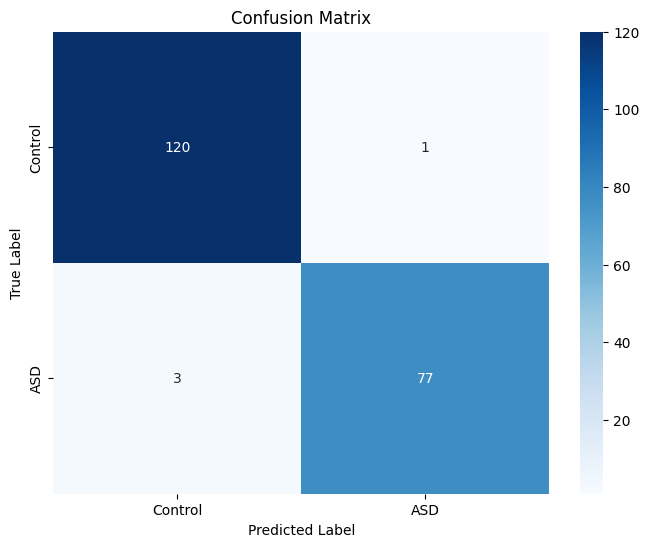

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=['Control', 'ASD'], yticklabels=['Control', 'ASD'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# Support vector machine

In [57]:
classifier = svm.SVC()
svc_model = general_pipeline(X_SMOTE, Y_SMOTE, classifier)

Risultati della cross-validation per tutte le combinazioni di iperparametri:
Parametri: {'classifier__C': 1}, Accuratezza media: 0.920 (±0.020), Precision media: 0.973, Richiamo medio: 0.865, F1-score medio: 0.915

Miglior parametro trovato:
1
Accuratezza media con il miglior parametro: 0.9202117572692794


# Comparison Between Classifiers

In [58]:
# Define a function to evaluate the AUC-ROC for a given model
def evaluate_roc_auc(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_proba)
    return auc_roc

knn_auc_roc = evaluate_roc_auc(knn_model, X_test, y_test)
rf_auc_roc = evaluate_roc_auc(rf_model, X_test, y_test)

# Print the results
print("K-Nearest Neighbors Classifier AUC-ROC:", knn_auc_roc)
print("Random Forest Classifier AUC-ROC:", rf_auc_roc)



K-Nearest Neighbors Classifier AUC-ROC: 0.9582128099173554
Random Forest Classifier AUC-ROC: 0.9954545454545455


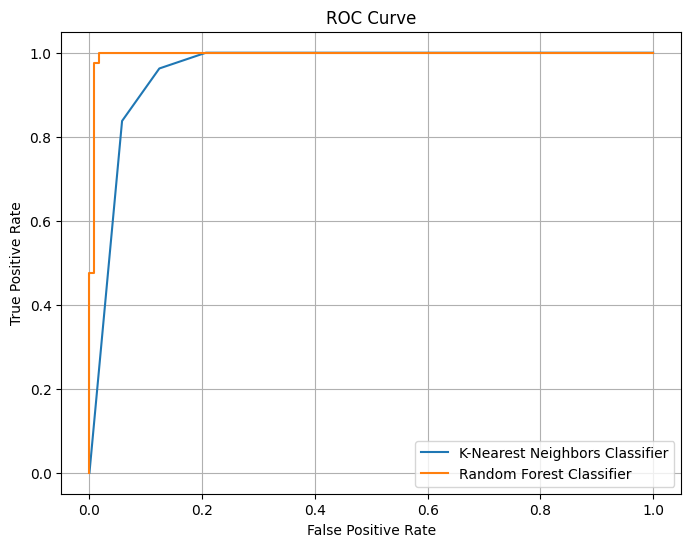

In [59]:
# Define a function to plot the ROC curve for a given model
def plot_roc_curve(model, X_test, y_test, model_name):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)

# Plot ROC curve for both models
y_test_binary = (y_test == 2).astype(int)

plt.figure(figsize=(8, 6))
plot_roc_curve(knn_model, X_test, y_test_binary, 'K-Nearest Neighbors Classifier')
plot_roc_curve(rf_model, X_test, y_test_binary, 'Random Forest Classifier')
plt.show()


# Logistic Regression and KNN Neighboors

In [60]:
numeric_columns, categorical_columns, ASD_phenotypic= of.select_columns(ASD_phenotypic)

# Feature selection